# Import e path

In [1]:
!pip install einops
!pip install vit_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.1 MB/s eta 0:00:00


In [2]:
models_save_path = "/content/drive/MyDrive/Tirocinio/Finale/Models/"
results_save_path_agent = "/content/drive/MyDrive/Tirocinio/Finale/Results/"
dataset_path = "/content/drive/MyDrive/Tirocinio/Transformers/Datasets/"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for image manipulation and machine learning
import torchvision
import torchvision.transforms as transforms
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn import functional
import torch.optim as optim

# Libraries for model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Libraries for tensor manipulation
from einops import rearrange
from einops.layers.torch import Rearrange

# Libraries for simulation environments (gym)
import gym

# Libraries for data visualization
import matplotlib.pyplot as plt

# Other common libraries
from collections import namedtuple
import math
import time
import os
import random


<h3> Seed and Device setting

In [5]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ViT Modified

In [7]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SimpleAgentViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dim_head = 64):
        super().__init__()

        self.patches = []

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        # Masking the input based on selected patches
        mask = torch.tensor(self.patches, dtype=torch.bool)
        x = x[:, mask, :]

        x = self.transformer(x)

        x = x.mean(dim = 1)

        x = self.to_latent(x)
        return self.linear_head(x)

    def set_patches(self, patch):
        mean = torch.mean(patch)
        selected = [0 if elem < mean else 1 for elem in patch]
        self.patches = selected

    def get_patches(self):
        return self.patches

    def get_att(self, img):
        *_, h, w, dtype = *img.shape, img.dtype

        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe

        attn, ff = self.transformer.layers[0]
        x = attn(x)
        x = torch.mean(x, dim=2)
        return x


# Dataset

<h3> Dataset Parameters

In [8]:
batch_size = 128
img_size = 32
dataset_name = "CIFAR10_BIG_"

## Train, validation and test

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_validation = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Prepare/download dataset
trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

validationset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=transform_validation)

dataset_size = len(validationset)
validation_size = int(0.95 * dataset_size)
test_size = dataset_size - validation_size

validationset, testset = data.random_split(validationset, [validation_size, test_size])

validation_loader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = trainset.classes
print(classes)

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Agent

### Functions for training and validation

<h3> Training function

In [23]:
def train_iter_agent(model, optimizer, data, target):
    start_time = time.time()

    model.train()

    optimizer.zero_grad()
    out = functional.log_softmax(model(data), dim=1)
    print(len(out))
    print("out is: ",out,"\n","target is: ",target)
    loss = functional.nll_loss(out, target)
    loss.backward()
    optimizer.step()

    iteration_time = time.time() - start_time

    return loss.item(), iteration_time

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h3> Validation function

In [11]:
def evaluate_agent(model, data_load, device):

    patches = model.get_patches()
    model.set_patches(torch.tensor([1 for i in range(len(patches))], dtype=torch.float))
    model.eval()


    elements = 0
    csamp = 0
    tloss = 0

    with torch.no_grad():
        for data, target in data_load:

            elements += len(data)
            data = data.to(device)
            target = target.to(device)

            output = functional.log_softmax(model(data), dim=1)
            loss = functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target).sum()

    loss_val = tloss / elements
    acc_val = (100.0 * csamp / elements).cpu()

    print('\nAverage test loss: ' + '{:.4f}'.format(loss_val) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(elements) + ' (' +
          '{:4.2f}'.format(acc_val) + '%)\n')

    model.set_patches(patches)

    return loss_val, acc_val


<h3> Function for training and validation

In [12]:
def train_validation_agent(model, optimizer, train_data, train_target, validation_loader, device):

  start_time = time.time()

  tr_loss = train_iter_agent(model, optimizer, train_data, train_target)

  val_loss, val_acc = evaluate_agent(model, validation_loader, device)

  iteration_time = time.time() - start_time

  return tr_loss, val_loss, val_acc, iteration_time

### Environment Custom

In [13]:
# Action space represented with a vector with one element for every feature
class MultiContinue():

    def __init__(self,  n_patch, device):
        self.n_patch = n_patch
        self.device = device

    def sample(self):
        action = np.random.rand(self.n_patch)
        return torch.tensor(action, device=self.device, dtype=torch.float)



class ViTEnv(gym.Env):
    def __init__(self, ViTnet, n_patch, optimizer, loss_weight, time_weight, device, n_patch_selected = 1, seed = None):
        super().__init__()

        self.ViTnet = ViTnet
        self.optimizer = optimizer

        self.seed = seed

        self.loss_weight = loss_weight
        self.time_weight = time_weight

        self.action_space = MultiContinue(n_patch, device)

        self.device = device

        self.train_loss_list = []
        self.train_time_list = []

    def step_train(self, action, train_data, train_target):

        self.ViTnet.set_patches(action)

        train_iter_agent(self.ViTnet, self.optimizer, train_data, train_target)


    def step_reward(self, action, train_data, train_target):

        self.ViTnet.set_patches(action)

        action = ViTnet.get_patches()

        print(f'  Patch list: {action}')
        print(f'  Selected Patches: {action.count(1)}')

        reward = self.get_reward(action, train_data = train_data, train_target = train_target)

        return self.get_state(train_data), reward


    def get_reward(self, action, train_data, train_target):

        train_loss, iteration_time = train_iter_agent(self.ViTnet, self.optimizer, train_data, train_target)

        self.train_time_list.append(iteration_time)
        self.train_loss_list.append(train_loss)

        num_zeros = action.count(0)
        ideal_zeros = len(action) - n_patch_selected;
        patches_reward = (- abs(num_zeros - ideal_zeros) / ideal_zeros)
        loss_reward = (self.train_loss_list[0]/train_loss)
        print(f'  loss_reward: {loss_reward}')
        print(f'  patches_reward: {patches_reward}')
        reward = loss_reward * self.loss_weight + patches_reward * self.time_weight

        return reward

    def get_state(self, data):
        with torch.no_grad():
          return self.ViTnet.get_att(data)

### Agent

<h3> ReplayBuffer

In [14]:
Transition = namedtuple('Transition',
                        ('state', 'new_state', 'reward'))


class ReplayBuffer(object):
    def __init__(self, capacity, batch_size):
        self.batch_size = batch_size
        self.memory = []
        self.capacity = capacity

    def push(self, *args):
        if len(self.memory) >= self.capacity:
            index_to_remove = random.randint(0, len(self.memory) - 1)
            self.memory.pop(index_to_remove)
        self.memory.append(Transition(*args))

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)


<h3> Network

In [15]:
class QNetwork(nn.Module):
    def __init__(self, n_patches):
        super(QNetwork, self).__init__()

        self.fc_layers = nn.Sequential(
            nn.Linear(n_patches, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, n_patches)
        )


    def forward(self, input):
        x = self.fc_layers(input)
        return x

<h3> Agente

In [16]:
class DQNAgent():
    def __init__(self, batch_size, att_dim, n_patches, buffer_size, gamma, tau, update_every, lr, env, device):
        self.batch_size = batch_size
        self.gamma = gamma

        # soft update parameter
        self.tau = tau
        # soft_update frequency
        self.step = 0
        self.update_every = update_every

        # learning rate
        self.lr = lr

        # device (CPU o GPU)
        self.device = device

        # environment
        self.env = env

        # agent net
        self.q_network = QNetwork(n_patches).to(self.device)
        # target net
        self.target_network = QNetwork(n_patches).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=lr, amsgrad=True)
        # replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size)


    def select_action(self, data, eps = 0.):

        sample = random.random()

        if sample > eps:
            with torch.no_grad():
                selected_batch = self.q_network(data)
                selected = torch.mean(selected_batch, dim=0)
                return selected
        else:
            selected = self.env.action_space.sample()
            return selected



    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample()

        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state).to(self.device)
        new_state_batch = torch.cat(batch.new_state).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        state_action_values = self.q_network(state_batch)

        with torch.no_grad():
            next_state_values = self.target_network(new_state_batch)

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch.unsqueeze(1)

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.q_network.parameters(), 100)
        self.optimizer.step()

        self.step += 1
        if self.step == self.update_every:
            self.soft_update()
            self.step = 0


    def soft_update(self):
        target_network_state_dict = self.target_network.state_dict()
        q_network_state_dict = self.q_network.state_dict()
        for key in q_network_state_dict:
            target_network_state_dict[key] = q_network_state_dict[key]*self.tau + target_network_state_dict[key]*(1-self.tau)
        self.target_network.load_state_dict(target_network_state_dict)

### Class for Training e il Testing

In [17]:
class TrainingTestingAgent():

    def __init__(self, buffer_batch_size, get_reward_every, batch_size, model, att_dim, n_patches, epochs, env, buffer_size, gamma, tau, update_every, lr, eps_end, eps_start, eps_decay, train_loader, validation_loader, device):

      self.env = env

      self.epochs = epochs
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_decay = eps_decay
      self.get_reward_every = get_reward_every

      self.batch_size = batch_size

      self.validation_acc = []
      self.validation_loss = []
      self.epoch_time_list = []
      self.validation_precision = []
      self.validation_recall = []
      self.validation_f1 = []

      self.ViTnet = model

      self.n_patches = n_patches

      # creazione agente
      self.agent = DQNAgent(buffer_batch_size, att_dim, n_patches, buffer_size, gamma, tau, update_every, lr, self.env, device)

      self.train_loader = train_loader
      self.validation_loader = validation_loader

      self.device = device


    def train_test(self):

      # lista dei reward ad ogni step
      step_reward = []
      selected_patch_list = []
      epoch = 0
      iteration = 0
      eps = self.eps_start

      while epoch < self.epochs:

          epoch += 1
          print(f'Epoch: {epoch}/{self.epochs}')

          start_time = time.time()
          samples = len(self.train_loader.dataset)

          for i, (data, target) in enumerate(self.train_loader):
              i +=1

              iteration += 1

              data = data.to(self.device)
              target = target.to(self.device)

              state = self.env.get_state(data)

              patch_list = self.agent.select_action(state, eps)

              selected_patch_list.append(patch_list)

              # alleno
              if i % self.get_reward_every != 0:
                self.env.step_train(patch_list, data, target)

              # alleno e testo il ViT
              else:
                new_state, reward = self.env.step_reward(patch_list, data, target)

                print(f'  Epsilon: {eps},   Reward: {reward}')

                step_reward.append(reward)

                reward = torch.full((self.batch_size, ), reward, dtype=torch.float32)

                if epoch != 1:
                  # inseriamo le osservazioni nella replayMemory
                  self.agent.memory.push(state, new_state, reward)

                  # ottimizziamo l'agente
                  self.agent.optimize_model()

              eps = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * iteration / self.eps_decay)

          print(f'\nInizio Testing')
          loss, acc, precision, recall, f1 = self.evaluate_epoch(self.validation_loader, models_save_path, dataset_name, self.device)

          epoch_time = time.time()-start_time

          self.validation_acc.append(acc)
          self.validation_loss.append(loss)
          self.validation_precision.append(precision)
          self.validation_recall.append(recall)
          self.validation_f1.append(f1)
          self.epoch_time_list.append(epoch_time)

          print(f'Epoch time: {epoch_time}')
          print("#"*40)


          print("#"*40)
          print('Episode End')
          print("#"*40)
          print("#"*40)

      return step_reward, selected_patch_list



    def evaluate_epoch(self, data_load, models_save_path, dataset_name, device):
        patches = self.ViTnet.get_patches()
        self.ViTnet.set_patches(torch.tensor([1 for i in range(len(patches))], dtype=torch.float))

        self.ViTnet.eval()


        elements = 0
        # predizioni corrette
        csamp = 0
        tloss = 0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, target in data_load:

                elements += len(data)
                data = data.to(device)
                target = target.to(device)

                predictions = self.ViTnet(data)

                output = functional.log_softmax(predictions, dim=1)
                loss = functional.nll_loss(output, target, reduction='sum')
                _, pred = torch.max(output, dim=1)

                predictions = torch.argmax(predictions, dim=1).cpu().numpy()

                tloss += loss.item()
                csamp += pred.eq(target).sum()

                all_predictions.extend(predictions)
                all_targets.extend(target.cpu())

        loss_val = tloss / elements
        acc_val = (100.0 * csamp / elements).cpu()


        print('\n\nAverage test loss: ' + '{:.4f}'.format(loss_val) +
              '  Accuracy:' + '{:5}'.format(csamp) + '/' +
              '{:5}'.format(elements) + ' (' +
              '{:4.2f}'.format(acc_val) + '%)\n')


        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')
        f1 = f1_score(all_targets, all_predictions, average='weighted')

        return loss_val, acc_val, precision, recall, f1


    def train_info(self):

        return {
                'train_loss': self.env.train_loss_list,
                'train_time': self.env.train_time_list,
                }

    def validation_info(self):
        return {
                'validation_loss': self.validation_loss,
                'validation_acc': [tensor.item() for tensor in self.validation_acc],
                'validation_precision': self.validation_precision,
                'validation_recall': self.validation_recall,
                'validation_f1': self.validation_f1,
                'epoch_time': self.epoch_time_list
                }

### Initialization

<h3> Parameters

In [18]:
buffer_batch_size = 8
buffer_size = 64

gamma = 0.95

eps_start = 1
eps_end = 0.01
eps = eps_start
eps_decay = 20000

lr = 0.01

tau = 0.1
update_every = 2

get_reward_every = 50

n_patch_selected = 30

time_weight = 20
loss_weight = 1

In [19]:
patch = 8
patch_size = int(img_size/patch)

att_dim = 128

epochs = 100
learning_rate = 0.001

ViTnet = SimpleAgentViT(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = len(classes),
    dim = att_dim,
    depth = 6,
    heads = 16,
    mlp_dim = 512
)

# Sposta il modello sulla GPU (se disponibile)
ViTnet.to(device)

# definiamo l'ottimizzatore
optimizer = optim.Adam(ViTnet.parameters(), lr=learning_rate)

In [20]:
total_patches = patch**2

env = ViTEnv(ViTnet, total_patches, optimizer, loss_weight, time_weight, device, n_patch_selected)

In [21]:
model = TrainingTestingAgent(epochs = epochs,
                             model = ViTnet,
                             get_reward_every = get_reward_every,
                             buffer_batch_size = buffer_batch_size,
                             batch_size = batch_size,
                             env = env,
                             att_dim = att_dim,
                             n_patches = total_patches,
                             buffer_size = buffer_size,
                             gamma = gamma,
                             tau = tau,
                             update_every = update_every,
                             lr = lr,
                             eps_end = eps_end,
                             eps_start = eps_start,
                             eps_decay = eps_decay,
                             train_loader = train_loader,
                             validation_loader = validation_loader,
                             device = device)

### Train

In [24]:
initial = time.time()
step_reward, selected_patch = model.train_test()
print(f'Total Time: {time.time()-initial}')

Epoch: 1/100
out is:  tensor([[-1.7200, -1.6022, -3.3514,  ..., -3.6133, -1.0470, -1.8304],
        [-2.4091, -1.2002, -3.8861,  ..., -3.2578, -1.5889, -1.1982],
        [-2.9955, -1.9304, -2.6588,  ..., -1.2765, -3.4301, -2.2218],
        ...,
        [-3.6873, -2.3605, -2.9058,  ..., -1.1098, -4.1192, -2.3684],
        [-1.4325, -2.5599, -3.4902,  ..., -4.9586, -0.6244, -2.4352],
        [-4.0429, -2.6864, -3.0794,  ..., -1.3404, -4.5982, -2.6292]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>) 
 target is:  tensor([0, 1, 9, 8, 2, 5, 0, 6, 8, 0, 7, 5, 0, 5, 3, 2, 8, 1, 1, 6, 1, 8, 9, 6,
        7, 0, 0, 2, 1, 2, 7, 2, 5, 6, 4, 0, 1, 6, 7, 8, 7, 1, 1, 0, 7, 4, 5, 4,
        8, 4, 9, 5, 9, 4, 5, 1, 9, 8, 4, 3, 2, 8, 3, 8, 1, 9, 6, 4, 4, 0, 0, 6,
        3, 5, 6, 9, 7, 7, 0, 2, 1, 5, 9, 5, 2, 6, 1, 8, 4, 2, 4, 0, 0, 6, 7, 5,
        4, 4, 2, 0, 3, 2, 3, 5, 4, 7, 3, 3, 8, 3, 3, 1, 0, 4, 7, 7, 0, 3, 2, 7,
        3, 8, 3, 6, 1, 9, 8, 9], device='cuda:0')
out is:  tensor([[-3.1858

KeyboardInterrupt: 

<h3> Train and Validation Informations

In [ ]:
results_train = model.train_info()
train_loss = results_train['train_loss']
train_time = results_train['train_time']

In [ ]:
results_validation = model.validation_info()
validation_loss = results_validation['validation_loss']
validation_acc = results_validation['validation_acc']

<h3> Saving Results in CSV format


In [ ]:
df = pd.DataFrame(results_train)

df.to_csv(f'{results_save_path_agent}{dataset_name}_train.csv', index=False)

In [ ]:
df = pd.DataFrame(results_validation)

df.to_csv(f'{results_save_path_agent}{dataset_name}_validation.csv', index=False)

### Plot of Results

<h3> Train Loss during iterations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


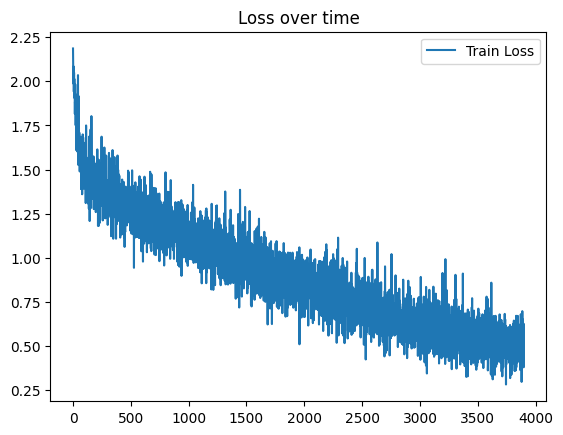

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label='Train Loss')

plt.legend()
plt.title('Loss over time')

plt.show()

<h3> Validation Loss during epochs

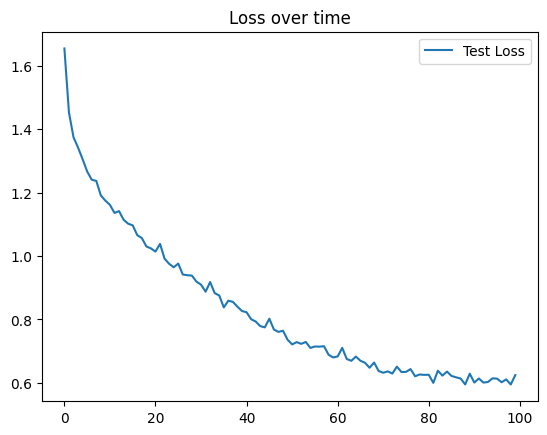

In [ ]:
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')

plt.legend()
plt.title('Loss over time')

plt.show()

<h3> Validation Accuracy during epochs

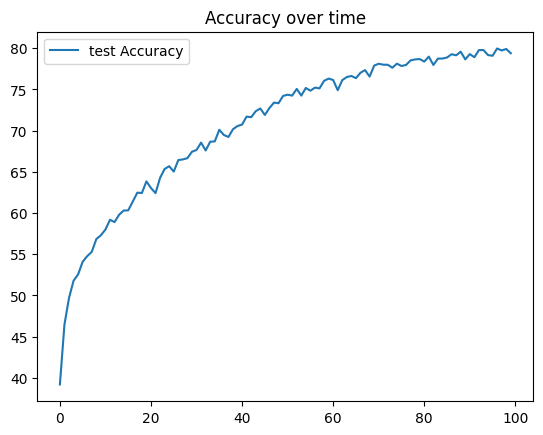

In [ ]:
x = range(len(validation_acc))
y = validation_acc

plt.plot(x, y, label='Validation Accuracy')

plt.legend()
plt.title('Accuracy over time')

plt.show()

In [ ]:
validation_acc

[39.20000076293945,
 46.47368240356445,
 49.69473648071289,
 51.78947448730469,
 52.55789566040039,
 54.09473419189453,
 54.7684211730957,
 55.294734954833984,
 56.842105865478516,
 57.30526351928711,
 58.0,
 59.17894744873047,
 58.9052619934082,
 59.78947448730469,
 60.30526351928711,
 60.32631301879883,
 61.38947296142578,
 62.47368240356445,
 62.43157958984375,
 63.842105865478516,
 63.031578063964844,
 62.421051025390625,
 64.273681640625,
 65.34736633300781,
 65.68421173095703,
 65.03157806396484,
 66.43157958984375,
 66.50526428222656,
 66.66315460205078,
 67.44210052490234,
 67.65263366699219,
 68.54737091064453,
 67.58946990966797,
 68.65263366699219,
 68.69473266601562,
 70.10526275634766,
 69.47368621826172,
 69.23157501220703,
 70.16841888427734,
 70.55789184570312,
 70.7368392944336,
 71.70526123046875,
 71.63157653808594,
 72.35789489746094,
 72.68421173095703,
 71.90525817871094,
 72.7368392944336,
 73.4000015258789,
 73.3263168334961,
 74.21052551269531,
 74.357894897460

## Evaluation for different Heuristics

In [ ]:
def evaluate_agent(agent, data_load, device, mode = False):

    agent.eval()

    elements = 0
    csamp = 0
    tloss = 0

    with torch.no_grad():
        for data, target in data_load:

            elements += len(data)
            data = data.to(device)
            target = target.to(device)

            state = env.get_state(data)

            if mode == "agent":
              action = model.agent.select_action(state)
            elif mode == "random":
              action = model.env.action_space.sample()
            else:
              action = torch.tensor([1 for i in range(len(model.env.action_space.sample()))], dtype = torch.float)

            ViTnet.set_patches(action)

            output = functional.log_softmax(agent(data), dim=1)
            loss = functional.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            tloss += loss.item()
            csamp += pred.eq(target).sum()

    loss_val = tloss / elements
    acc_val = (100.0 * csamp / elements).cpu()

    print('\nAverage validation loss: ' + '{:.4f}'.format(loss_val) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(elements) + ' (' +
          '{:4.2f}'.format(acc_val) + '%)\n')

    return loss_val, acc_val


### Train

<h3> All Patches

In [ ]:
evaluate_agent(ViTnet, train_loader, device)


Average test loss: 0.2968  Accuracy:44753/50000 (89.51%)



(0.2968252645874023, tensor(89.5060))

<h3> Patches Selected By agent

In [ ]:
evaluate_agent(ViTnet, train_loader, device, mode = "agent")


Average test loss: 0.4375  Accuracy:42256/50000 (84.51%)



(0.4374778049850464, tensor(84.5120))

<h3> Random Patches

In [ ]:
evaluate_agent(ViTnet, train_loader, device, mode = "random")


Average test loss: 0.5301  Accuracy:40476/50000 (80.95%)



(0.5301350287628174, tensor(80.9520))

### Validation

<h3> All Patches

In [ ]:
evaluate_agent(ViTnet, test_loader, device)


Average test loss: 0.6246  Accuracy: 7542/ 9500 (79.39%)



(0.6245820922851563, tensor(79.3895))

<h3> Patches Selected By agent

In [ ]:
evaluate_agent(ViTnet, test_loader, device, mode = "agent")


Average test loss: 0.7428  Accuracy: 7201/ 9500 (75.80%)



(0.7427533075433028, tensor(75.8000))

<h3> Random Patches

In [ ]:
evaluate_agent(ViTnet, test_loader, device, mode = "random")


Average test loss: 0.8210  Accuracy: 6964/ 9500 (73.31%)



(0.8210267769662958, tensor(73.3053))